In [3]:
# Import necessary libraries
import pandas as pd
import os

# Define file paths
sentiment_file = '../dataset/raw_analyst_ratings.csv'  # Replace with actual path
stock_folder = '../dataset/yfinance_data'        # Folder containing stock datasets

# Load sentiment data
sentiment_data = pd.read_csv(sentiment_file)

# Normalize 'date' column in sentiment data to remove timezones and set to date format
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'], errors='coerce').dt.date

# Drop rows where 'date' could not be converted
sentiment_data = sentiment_data.dropna(subset=['date'])
print(f"Cleaned sentiment data: {len(sentiment_data)} rows remaining")

# List of stock data files and their corresponding company names
company_files = {
    'AMZN': 'AMZN_historical_data.csv',
    'GOOG': 'GOOG_historical_data.csv',
    'META': 'META_historical_data.csv',
    'MSFT': 'MSFT_historical_data.csv',
    'NVDA': 'NVDA_historical_data.csv',
    'TSLA': 'TSLA_historical_data.csv',
    'AAPL': 'AAPL_historical_data.csv'
}

# Initialize a list to store merged datasets
merged_dataframes = []

# Debugging: Display date ranges for stock data and sentiment data
for company, file in company_files.items():
    file_path = os.path.join(stock_folder, file)
    
    # Load stock data
    stock_data = pd.read_csv(file_path)
    stock_data.columns = stock_data.columns.str.strip().str.lower()
    stock_data['date'] = pd.to_datetime(stock_data['date'], errors='coerce').dt.date
    stock_data = stock_data.dropna(subset=['date'])
    
    print(f"Stock Data - {company} Date Range: {stock_data['date'].min()} to {stock_data['date'].max()}")
    
    # Filter sentiment data
    company_sentiment = sentiment_data[sentiment_data['stock'] == company].copy()
    print(f"Sentiment Data - {company} Rows: {len(company_sentiment)}")
    
    if not company_sentiment.empty:
        print(f"Sentiment Data - {company} Date Range: {company_sentiment['date'].min()} to {company_sentiment['date'].max()}")

    # Find overlapping dates
    overlap_dates = set(stock_data['date']) & set(company_sentiment['date'])
    print(f"Overlap for {company}: {len(overlap_dates)} dates")
    
    if overlap_dates:
        # Filter stock and sentiment data to overlapping dates
        stock_data = stock_data[stock_data['date'].isin(overlap_dates)]
        company_sentiment = company_sentiment[company_sentiment['date'].isin(overlap_dates)]

        # Add a column to identify the company
        stock_data['company'] = company

        # Merge stock data with sentiment data on 'date'
        merged_df = pd.merge(stock_data, company_sentiment, on='date', how='inner')

        # Append the merged dataframe to the list
        merged_dataframes.append(merged_df)

# Combine all merged datasets
if merged_dataframes:
    final_merged_data = pd.concat(merged_dataframes, ignore_index=True)
    print(final_merged_data.head())
    
    # Save the combined dataset for further analysis
    final_merged_data.to_csv('combined_sentiment_stock_data.csv', index=False)
    print("Combined dataset saved as 'combined_sentiment_stock_data.csv'")
else:
    print("No valid stock data files were merged. Check for issues in stock datasets.")


Cleaned sentiment data: 55987 rows remaining
Stock Data - AMZN Date Range: 1997-05-15 to 2024-07-30
Sentiment Data - AMZN Rows: 10
Sentiment Data - AMZN Date Range: 2020-06-09 to 2020-06-10
Overlap for AMZN: 2 dates
Stock Data - GOOG Date Range: 2004-08-19 to 2024-07-30
Sentiment Data - GOOG Rows: 10
Sentiment Data - GOOG Date Range: 2020-06-04 to 2020-06-10
Overlap for GOOG: 5 dates
Stock Data - META Date Range: 2012-12-12 to 2024-07-30
Sentiment Data - META Rows: 0
Overlap for META: 0 dates
Stock Data - MSFT Date Range: 1986-03-13 to 2024-07-30
Sentiment Data - MSFT Rows: 0
Overlap for MSFT: 0 dates
Stock Data - NVDA Date Range: 1999-01-22 to 2024-07-30
Sentiment Data - NVDA Rows: 10
Sentiment Data - NVDA Date Range: 2020-05-31 to 2020-06-10
Overlap for NVDA: 4 dates
Stock Data - TSLA Date Range: 2010-06-29 to 2024-07-30
Sentiment Data - TSLA Rows: 10
Sentiment Data - TSLA Date Range: 2020-06-10 to 2020-06-10
Overlap for TSLA: 1 dates
Stock Data - AAPL Date Range: 1980-12-12 to 2024-

In [5]:
# Inspect sentiment data structure
print("Inspecting Sentiment Data...")
print("Columns in Sentiment Data:", sentiment_data.columns.tolist())
print(sentiment_data.head())

# Check for possible column mismatches
if 'sentiment' not in sentiment_data.columns:
    print("Possible issues with the dataset:")
    print("Does a column representing sentiment exist under a different name?")
else:
    print("The 'sentiment' column is present and ready for processing.")

Inspecting Sentiment Data...
Columns in Sentiment Data: ['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock']
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                 dat

In [6]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis to headlines
sentiment_data['sentiment'] = sentiment_data['headline'].apply(lambda x: 
    'positive' if sia.polarity_scores(x)['compound'] > 0.05 else 
    'negative' if sia.polarity_scores(x)['compound'] < -0.05 else 
    'neutral'
)

print(sentiment_data[['headline', 'sentiment']].head())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...


                                            headline sentiment
0            Stocks That Hit 52-Week Highs On Friday   neutral
1         Stocks That Hit 52-Week Highs On Wednesday   neutral
2                      71 Biggest Movers From Friday   neutral
3       46 Stocks Moving In Friday's Mid-Day Session   neutral
4  B of A Securities Maintains Neutral on Agilent...  positive


In [7]:
# Import necessary libraries
import os
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Define file paths
sentiment_file = '../dataset/raw_analyst_ratings.csv'  # Replace with the actual path
stock_folder = '../dataset/yfinance_data'             # Folder containing stock datasets

# Load sentiment data
sentiment_data = pd.read_csv(sentiment_file)

# Normalize 'date' column in sentiment data
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'], errors='coerce').dt.tz_localize(None)
sentiment_data = sentiment_data.dropna(subset=['date'])

# Perform sentiment analysis on the 'headline' column
sentiment_data['sentiment'] = sentiment_data['headline'].apply(
    lambda x: 'positive' if sia.polarity_scores(x)['compound'] > 0.05 else
              'negative' if sia.polarity_scores(x)['compound'] < -0.05 else 'neutral'
)

print(sentiment_data[['headline', 'sentiment']].head())

# Define stock data files
company_files = {
    'AMZN': 'AMZN_historical_data.csv',
    'GOOG': 'GOOG_historical_data.csv',
    'META': 'META_historical_data.csv',
    'MSFT': 'MSFT_historical_data.csv',
    'NVDA': 'NVDA_historical_data.csv',
    'TSLA': 'TSLA_historical_data.csv',
    'AAPL': 'AAPL_historical_data.csv'
}

# Initialize a list to store merged datasets
merged_dataframes = []

for company, file in company_files.items():
    file_path = os.path.join(stock_folder, file)
    stock_data = pd.read_csv(file_path)
    
    # Standardize column names and convert 'date' to datetime
    stock_data.columns = stock_data.columns.str.strip().str.lower()
    stock_data['date'] = pd.to_datetime(stock_data['date'], errors='coerce')
    stock_data = stock_data.dropna(subset=['date'])
    
    # Filter sentiment data for the company
    company_sentiment = sentiment_data[sentiment_data['stock'] == company.upper()]
    
    # Merge stock and sentiment data
    merged_df = pd.merge(stock_data, company_sentiment, on='date', how='inner')
    merged_dataframes.append(merged_df)

# Combine all merged datasets
if merged_dataframes:
    final_merged_data = pd.concat(merged_dataframes, ignore_index=True)

    # Map sentiment to numerical scores
    sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
    final_merged_data['sentiment_score'] = final_merged_data['sentiment'].map(sentiment_mapping)

    # Feature engineering
    final_merged_data['price_change_pct'] = ((final_merged_data['close'] - final_merged_data['open']) / 
                                             final_merged_data['open']) * 100
    final_merged_data['volume_normalized'] = (final_merged_data['volume'] - final_merged_data['volume'].min()) / \
                                             (final_merged_data['volume'].max() - final_merged_data['volume'].min())
    final_merged_data['sentiment_price_interaction'] = (final_merged_data['sentiment_score'] * 
                                                        final_merged_data['price_change_pct'])

    # Save the final dataset
    final_merged_data.to_csv('engineered_sentiment_stock_data.csv', index=False)
    print("Feature-engineered dataset saved as 'engineered_sentiment_stock_data.csv'")
else:
    print("No data merged. Check sentiment and stock datasets.")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                            headline sentiment
0            Stocks That Hit 52-Week Highs On Friday   neutral
1         Stocks That Hit 52-Week Highs On Wednesday   neutral
2                      71 Biggest Movers From Friday   neutral
3       46 Stocks Moving In Friday's Mid-Day Session   neutral
4  B of A Securities Maintains Neutral on Agilent...  positive
Feature-engineered dataset saved as 'engineered_sentiment_stock_data.csv'


In [11]:
import pandas as pd
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download NLTK resources
nltk.download('vader_lexicon')

# Load the combined dataset
combined_file = 'combined_sentiment_stock_data.csv'
try:
    combined_data = pd.read_csv(combined_file)
    print(f"Loaded combined data with {len(combined_data)} rows.")
except FileNotFoundError:
    raise FileNotFoundError(f"File {combined_file} not found. Ensure the combined file exists.")

# Validate loaded data
print("Columns in combined data:", combined_data.columns.tolist())
print(combined_data.head())

# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Add a sentiment score column if not already present
if 'sentiment' not in combined_data.columns:
    print("Calculating sentiment scores for headlines...")
    combined_data['sentiment'] = combined_data['headline'].apply(
        lambda x: 'positive' if sia.polarity_scores(x)['compound'] > 0.05 else
                  ('negative' if sia.polarity_scores(x)['compound'] < -0.05 else 'neutral')
    )
    print("Sentiment scores added.")

# Map sentiment to numerical scores
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
combined_data['sentiment_score'] = combined_data['sentiment'].map(sentiment_mapping)

# Handle missing sentiment scores (optional)
combined_data['sentiment_score'] = combined_data['sentiment_score'].fillna(0)

# Calculate percentage price change
if 'close' in combined_data.columns and 'open' in combined_data.columns:
    combined_data['price_change_pct'] = (
        (combined_data['close'] - combined_data['open']) / combined_data['open']) * 100
else:
    raise KeyError("Columns 'close' and/or 'open' are missing in the dataset. Please check the dataset structure.")

# Normalize trading volumes (Min-Max Normalization)
if 'volume' in combined_data.columns:
    combined_data['volume_normalized'] = (
        combined_data['volume'] - combined_data['volume'].min()) / \
        (combined_data['volume'].max() - combined_data['volume'].min())
else:
    raise KeyError("Column 'volume' not found in the dataset. Please check the dataset structure.")

# Create an interaction feature (Sentiment Score * Price Change)
combined_data['sentiment_price_interaction'] = (
    combined_data['sentiment_score'] * combined_data['price_change_pct'])

# Validate the transformed data
print("\nTransformed Data Preview:")
print(combined_data[['date', 'company', 'sentiment', 'price_change_pct',
                     'volume_normalized', 'sentiment_price_interaction']].head())

# Save the feature-engineered dataset
engineered_file = 'engineered_sentiment_stock_data.csv'
combined_data.to_csv(engineered_file, index=False)
print(f"Feature-engineered dataset saved as '{engineered_file}'")


Loaded combined data with 49 rows.
Columns in combined data: ['date', 'open', 'high', 'low', 'close', 'adj close', 'volume', 'dividends', 'stock splits', 'company', 'Unnamed: 0', 'headline', 'url', 'publisher', 'stock']
         date     open        high         low       close   adj close  \
0  2020-06-09  126.472  131.321503  126.250000  130.042999  130.042999   
1  2020-06-09  126.472  131.321503  126.250000  130.042999  130.042999   
2  2020-06-09  126.472  131.321503  126.250000  130.042999  130.042999   
3  2020-06-09  126.472  131.321503  126.250000  130.042999  130.042999   
4  2020-06-10  132.250  136.117493  131.313004  132.372498  132.372498   

      volume  dividends  stock splits company  Unnamed: 0  \
0  103520000        0.0           0.0    AMZN       76875   
1  103520000        0.0           0.0    AMZN       76876   
2  103520000        0.0           0.0    AMZN       76877   
3  103520000        0.0           0.0    AMZN       76878   
4   98920000        0.0       

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


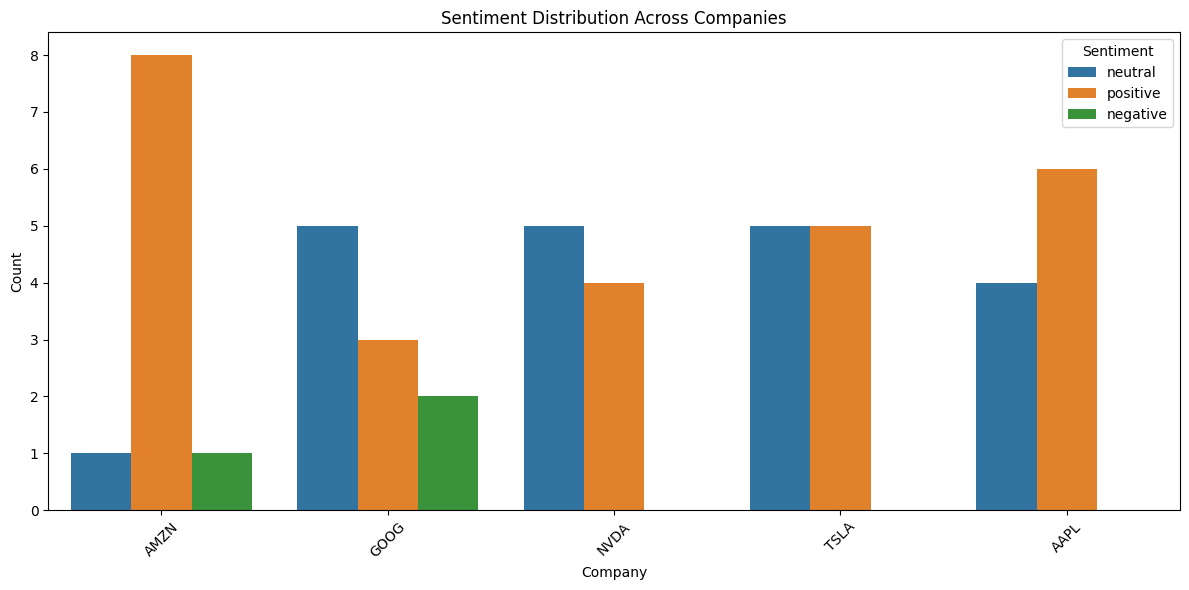

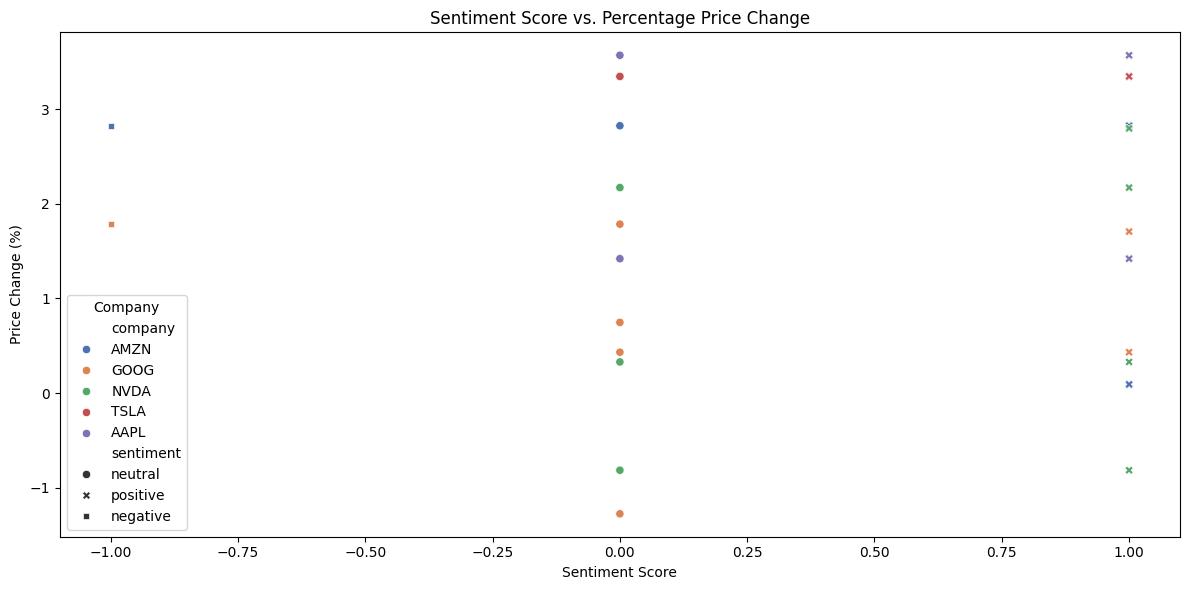

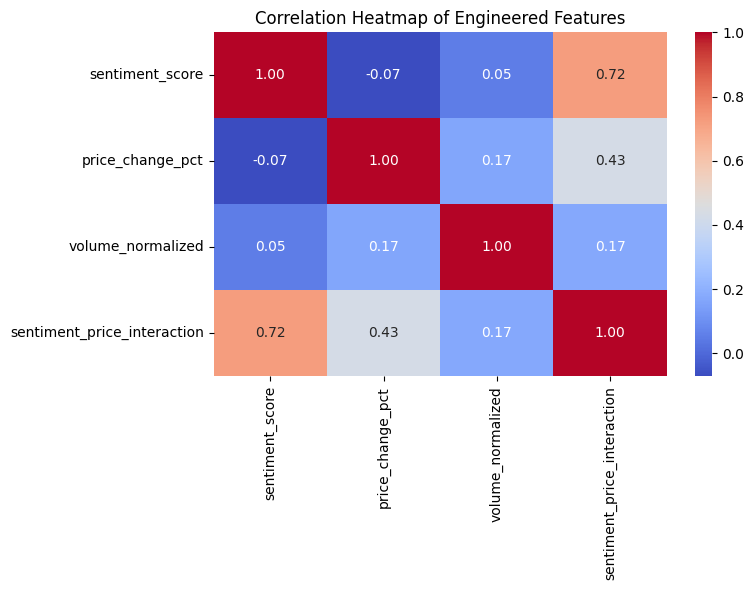

In [12]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Load the engineered dataset
engineered_data_file = 'engineered_sentiment_stock_data.csv'
engineered_data = pd.read_csv(engineered_data_file)

# Check for any null values in key columns
if engineered_data.isnull().sum().sum() > 0:
    print("Warning: Missing values detected. Cleaning the dataset.")
    engineered_data = engineered_data.dropna()

# Visualization 1: Sentiment Distribution Across Companies
plt.figure(figsize=(12, 6))
sns.countplot(data=engineered_data, x='company', hue='sentiment')
plt.title('Sentiment Distribution Across Companies')
plt.xlabel('Company')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization 2: Sentiment Score vs. Price Change
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=engineered_data, 
    x='sentiment_score', 
    y='price_change_pct', 
    hue='company', 
    style='sentiment', 
    palette='deep'
)
plt.title('Sentiment Score vs. Percentage Price Change')
plt.xlabel('Sentiment Score')
plt.ylabel('Price Change (%)')
plt.legend(title='Company')
plt.tight_layout()
plt.show()

# Visualization 3: Correlation Heatmap
correlation_matrix = engineered_data[['sentiment_score', 'price_change_pct', 
                                      'volume_normalized', 'sentiment_price_interaction']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap of Engineered Features')
plt.tight_layout()
plt.show()


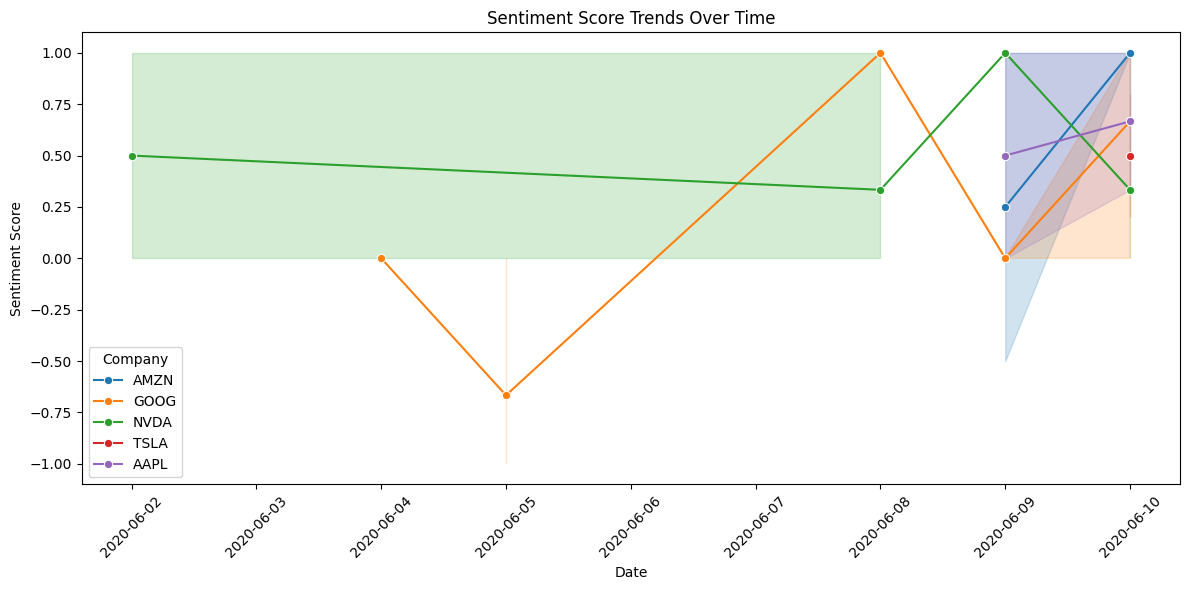

In [13]:
# Sentiment Time Series
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'date' column to datetime format
engineered_data['date'] = pd.to_datetime(engineered_data['date'])

# Plot sentiment score trends over time for each company
plt.figure(figsize=(12, 6))
sns.lineplot(data=engineered_data, x='date', y='sentiment_score', hue='company', marker="o")
plt.title("Sentiment Score Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

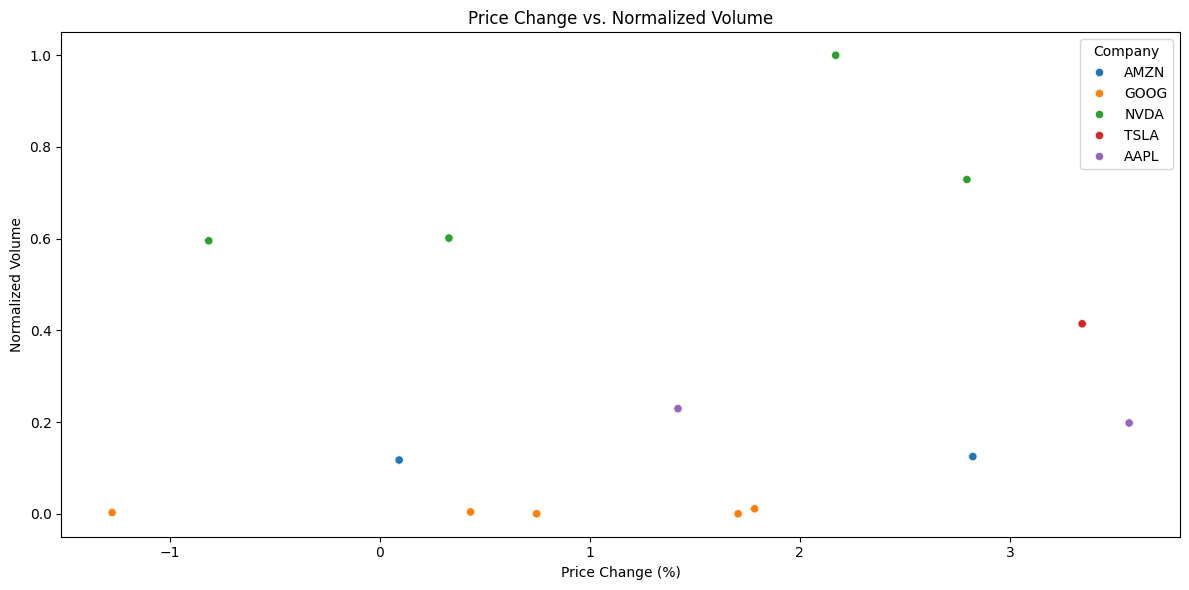

In [14]:
 #Price Change vs. Volume
# Scatter plot of percentage price change vs. normalized volume
plt.figure(figsize=(12, 6))
sns.scatterplot(data=engineered_data, x='price_change_pct', y='volume_normalized', hue='company')
plt.title("Price Change vs. Normalized Volume")
plt.xlabel("Price Change (%)")
plt.ylabel("Normalized Volume")
plt.legend(title="Company")
plt.tight_layout()
plt.show()

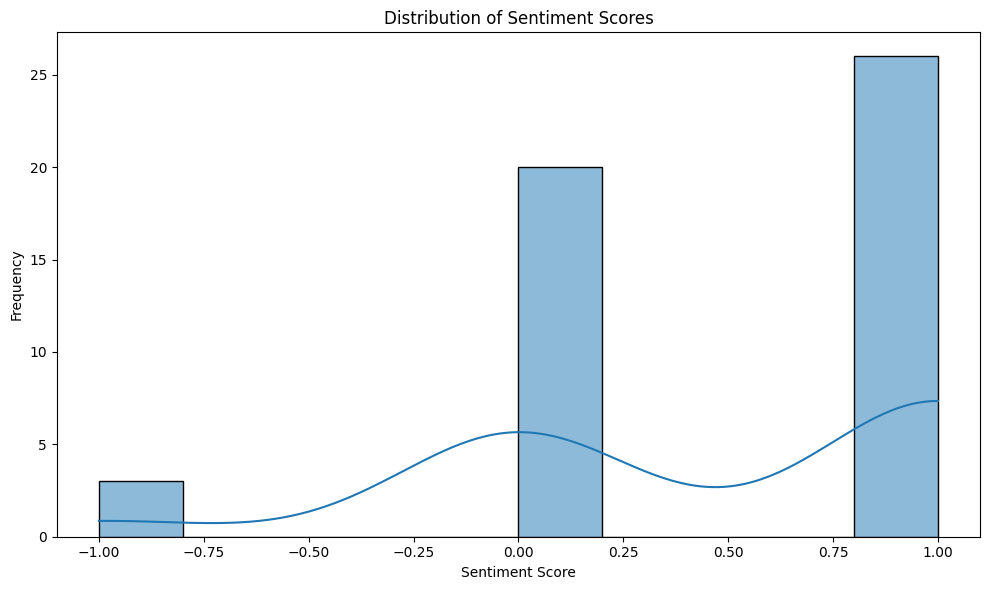

In [15]:
#Sentiment Score Distribution

# Distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(engineered_data['sentiment_score'], kde=True, bins=10)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

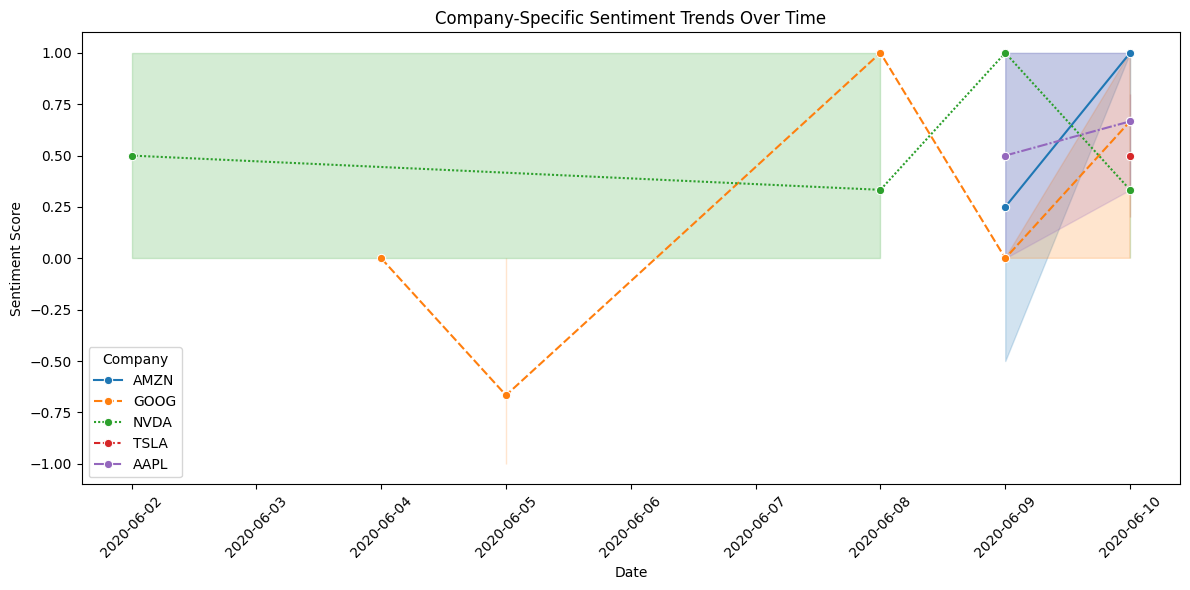

In [16]:
#Company-Specific Sentiment Trends

# Plot sentiment trends for each company
plt.figure(figsize=(12, 6))
sns.lineplot(data=engineered_data, x='date', y='sentiment_score', hue='company', marker="o", style='company')
plt.title("Company-Specific Sentiment Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_12068\1359286697.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=engineered_data, x='sentiment', y='price_change_pct', ci=None)


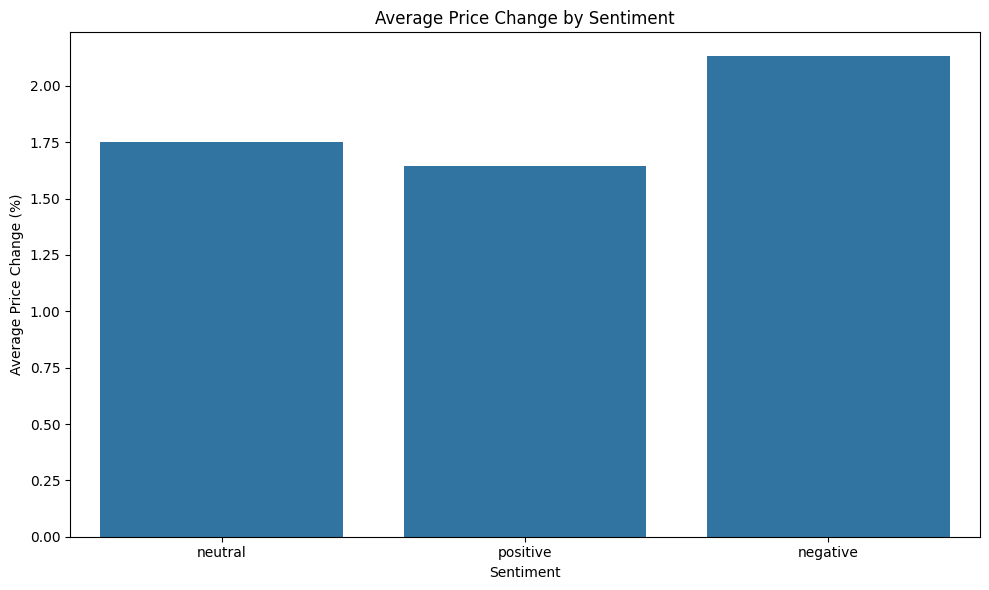

In [17]:
#Average Price Change by Sentiment

# Bar plot of average price change grouped by sentiment
plt.figure(figsize=(10, 6))
sns.barplot(data=engineered_data, x='sentiment', y='price_change_pct', ci=None)
plt.title("Average Price Change by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Price Change (%)")
plt.tight_layout()
plt.show()

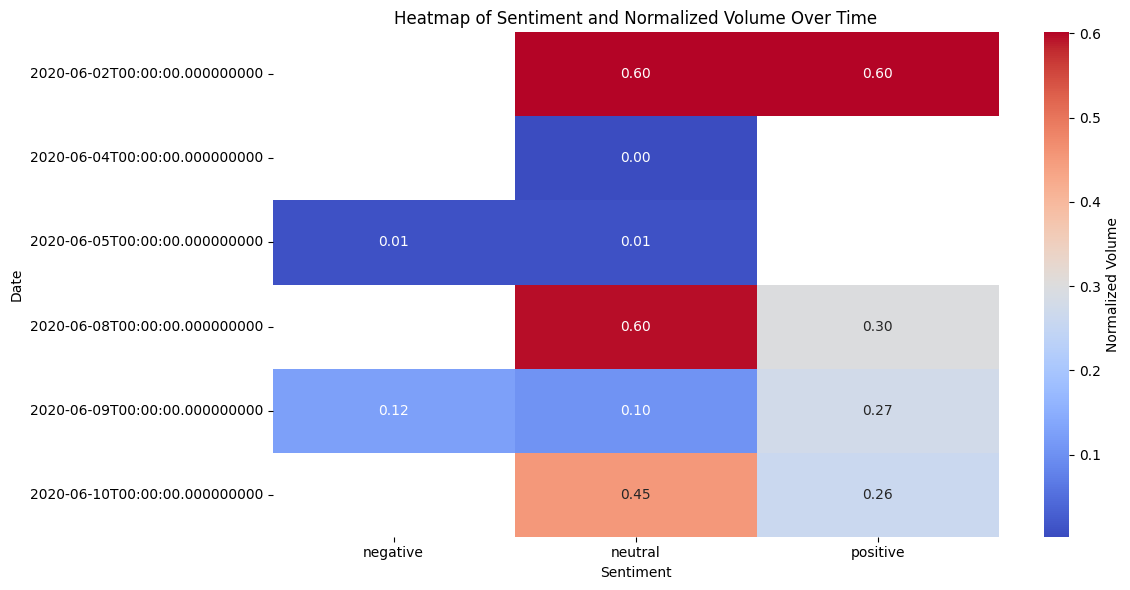

In [18]:
#Heatmap of Volume and Sentiment Interaction

# Pivot table for heatmap
heatmap_data = engineered_data.pivot_table(index='date', columns='sentiment', values='volume_normalized', aggfunc='mean')

# Heatmap of sentiment and normalized volume interaction
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.2f', cbar_kws={'label': 'Normalized Volume'})
plt.title("Heatmap of Sentiment and Normalized Volume Over Time")
plt.xlabel("Sentiment")
plt.ylabel("Date")
plt.tight_layout()
plt.show()

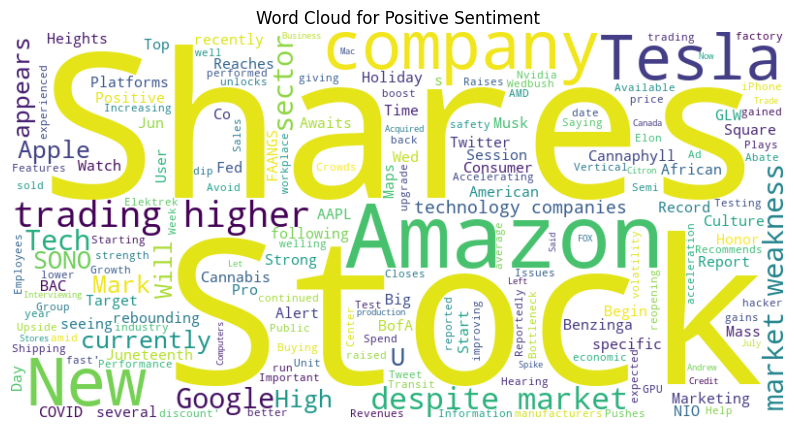

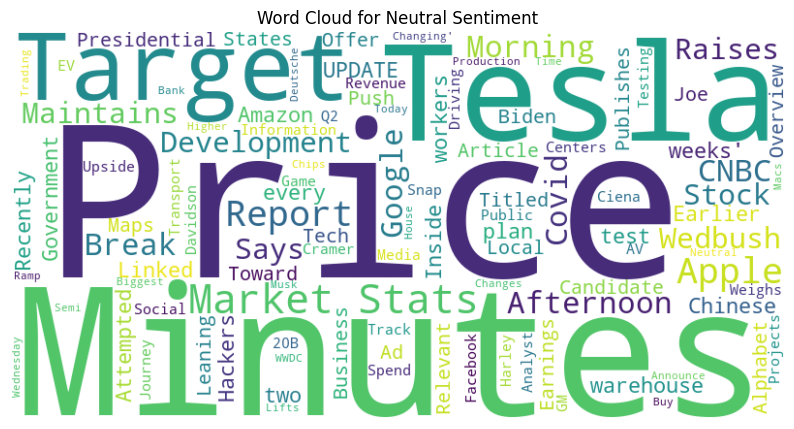

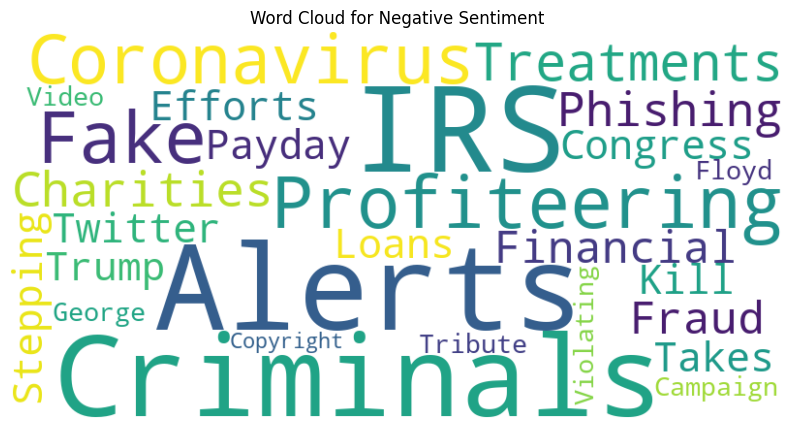

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word clouds for each sentiment
sentiments = ['positive', 'neutral', 'negative']
for sentiment in sentiments:
    sentiment_text = " ".join(engineered_data[engineered_data['sentiment'] == sentiment]['headline'].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sentiment_text)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {sentiment.capitalize()} Sentiment")
    plt.axis("off")
    plt.show()


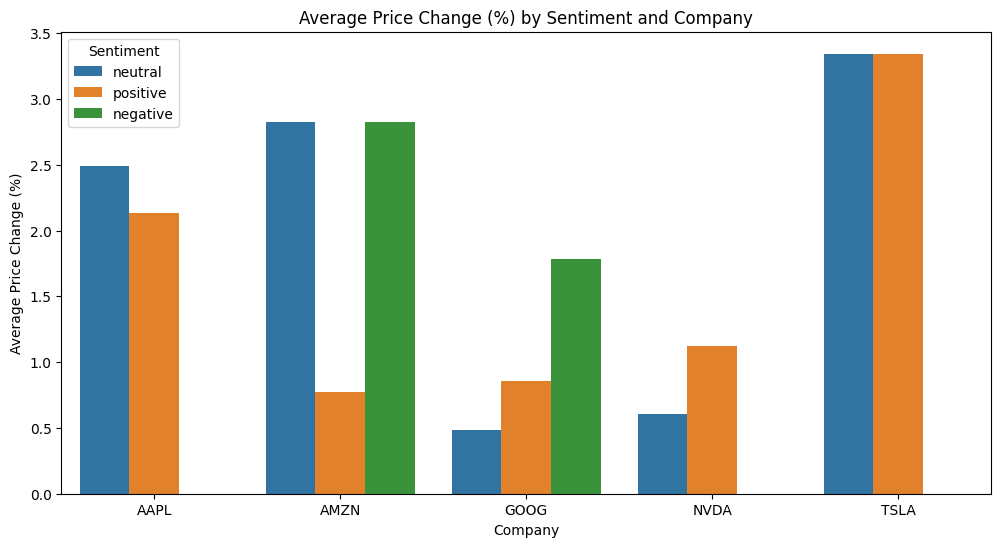

Correlation Analysis:
                   sentiment_score  price_change_pct  volume_normalized
sentiment_score           1.000000         -0.072299           0.052999
price_change_pct         -0.072299          1.000000           0.165948
volume_normalized         0.052999          0.165948           1.000000

Key Terms from Word Clouds:
Key terms for Positive Sentiment:
BofA Raises Amazon Target On Sales Upside, Accelerating Unit Growth Amazon shares are trading higher despite market weakness. Not currently seeing company-specific news. How Cannabis Company Cannaphyll Is Marketing On Mass-Consumer Platforms, Google And Amazon Tech Stocks And FAANGS Strong Again To  ...


Key terms for Neutral Sentiment:
'Inside Amazon's plan to test warehouse workers for Covid-19 every two weeks' -Earlier CNBC Report UPDATE: Chinese Government-Linked Hackers Recently Attempted To Break Into Presidential Candidate Joe Biden CNBC Publishes Article Titled: States are Leaning Toward a Push to Break Up Goog

In [21]:
# Analyze average price change grouped by sentiment and company
sentiment_performance = engineered_data.groupby(['company', 'sentiment'])['price_change_pct'].mean().reset_index()

# Plot the average price change by sentiment for each company
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=sentiment_performance, x='company', y='price_change_pct', hue='sentiment')
plt.title('Average Price Change (%) by Sentiment and Company')
plt.xlabel('Company')
plt.ylabel('Average Price Change (%)')
plt.legend(title='Sentiment')
plt.show()

# Analyze correlations and display as insights
print("Correlation Analysis:")
correlation_matrix = engineered_data[['sentiment_score', 'price_change_pct', 'volume_normalized']].corr()
print(correlation_matrix)

# Display key terms from word clouds
print("\nKey Terms from Word Clouds:")
for sentiment in ['positive', 'neutral', 'negative']:
    sentiment_text = " ".join(engineered_data[engineered_data['sentiment'] == sentiment]['headline'].dropna())
    print(f"Key terms for {sentiment.capitalize()} Sentiment:")
    print(sentiment_text[:300], '...')  # Display a snippet of the key terms
    print("\n")


Dataset loaded successfully with 49 rows.


C:\Users\Admin\AppData\Local\Temp\ipykernel_12068\3988238316.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=data, x='sentiment', y='volume_normalized', hue='company', ci=None)


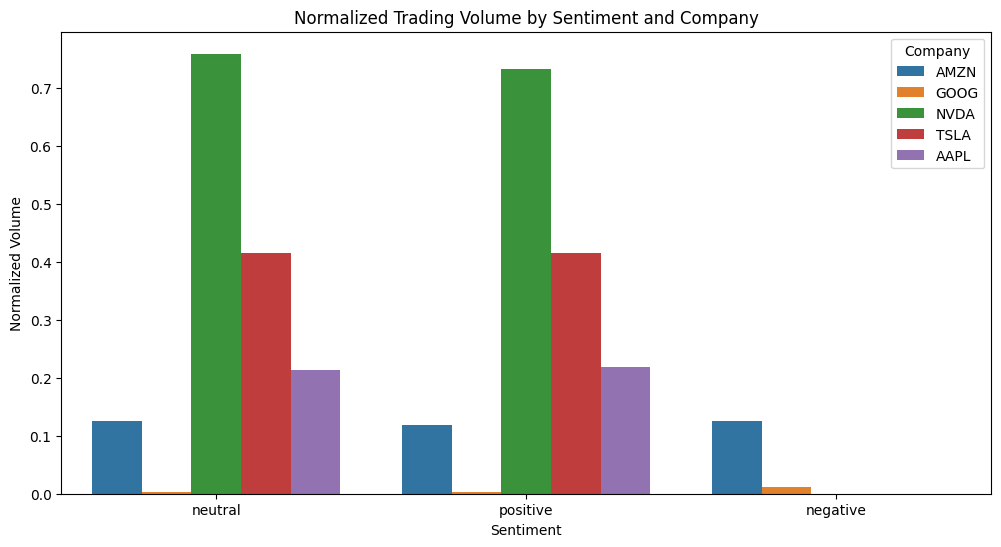

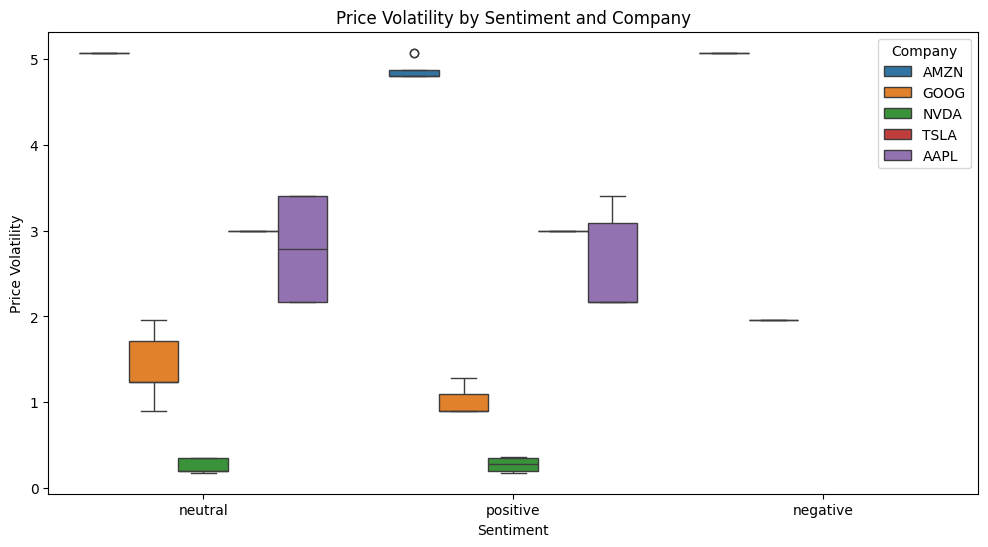

<Figure size 1400x600 with 0 Axes>

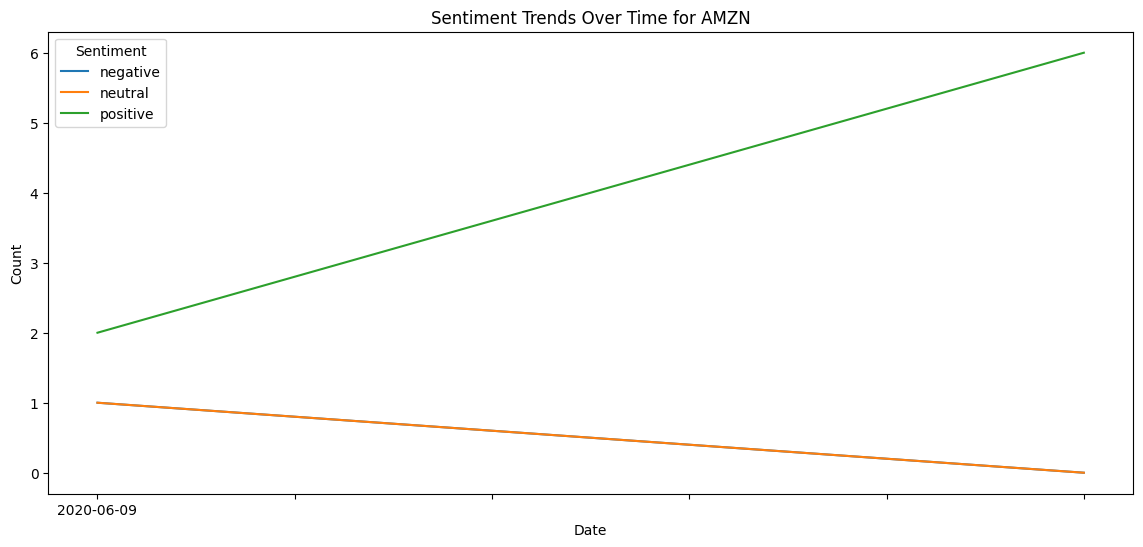

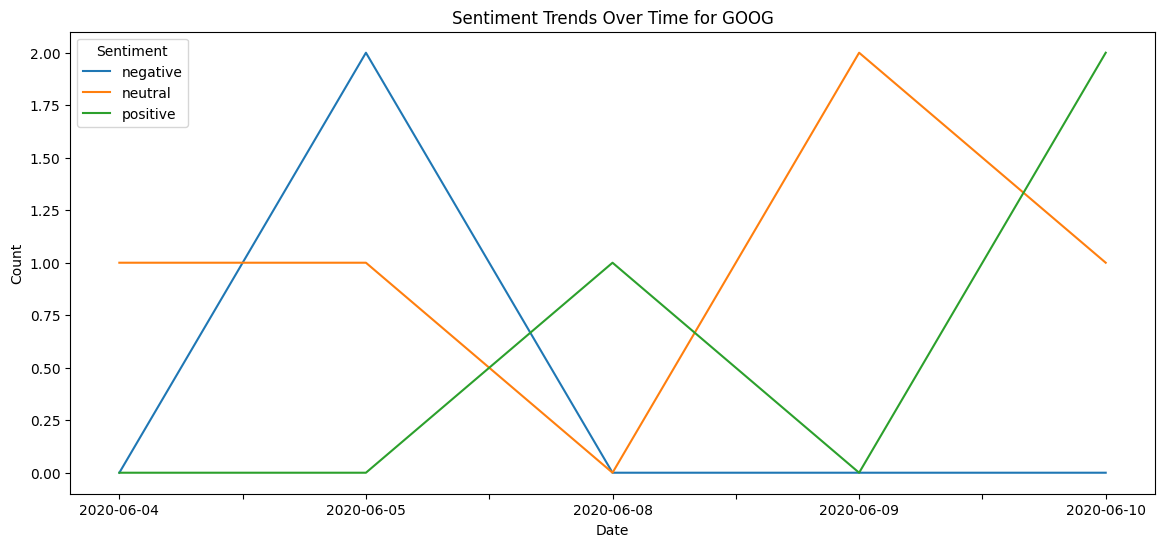

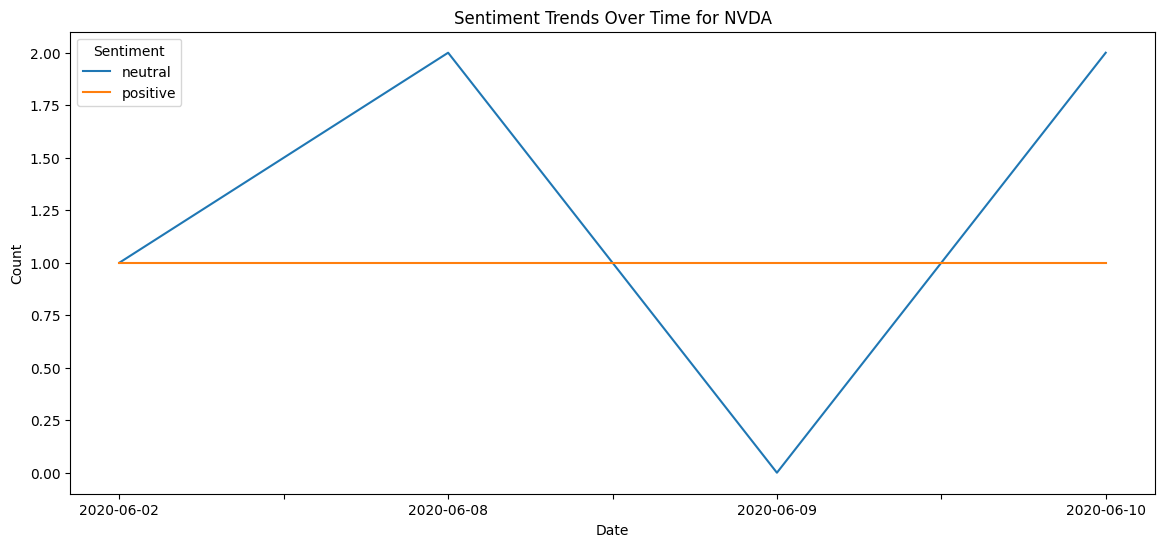

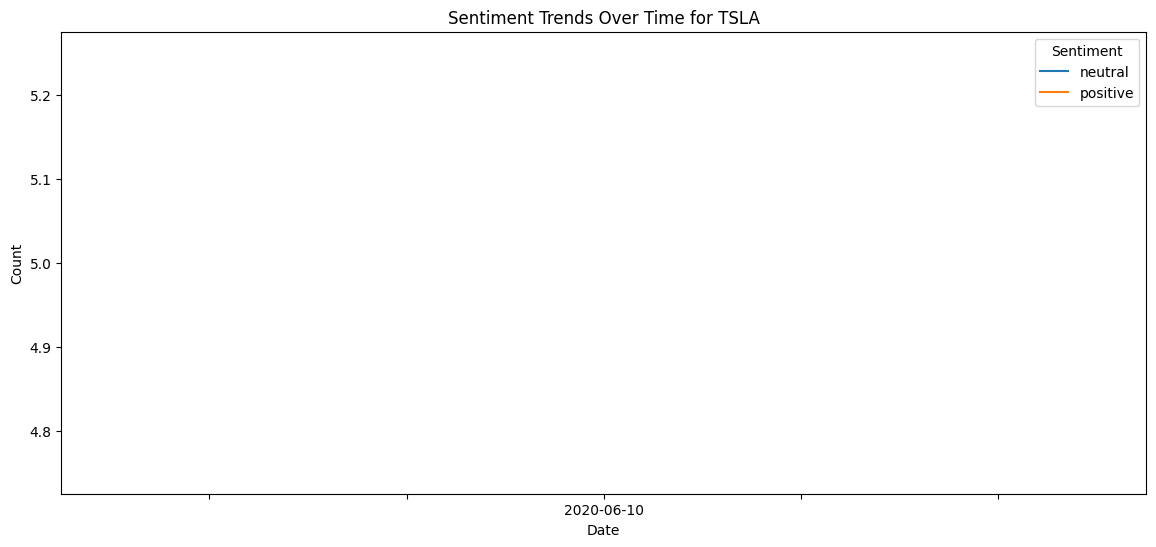

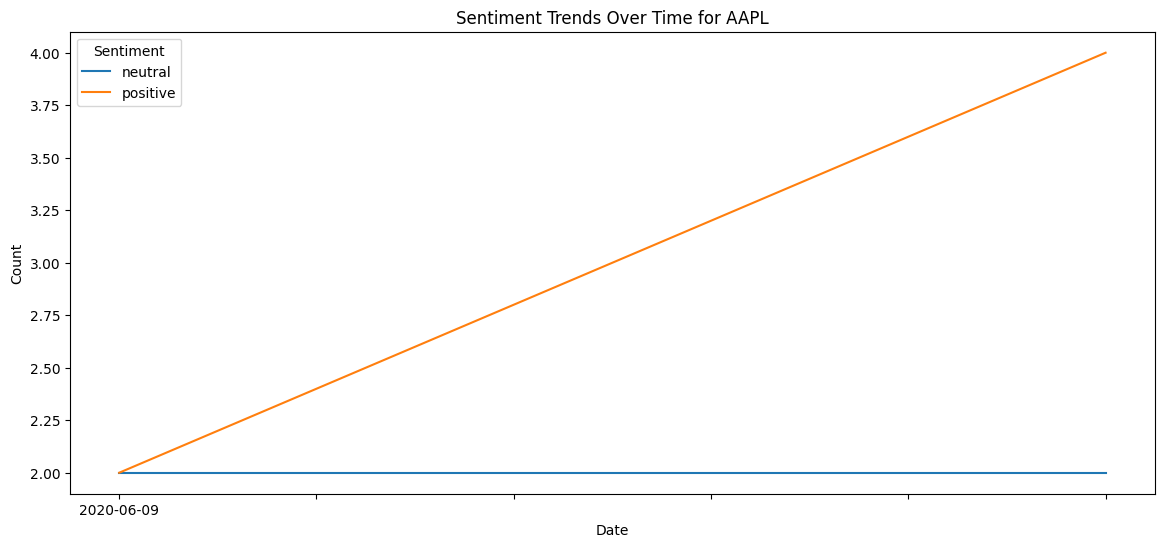

C:\Users\Admin\AppData\Local\Temp\ipykernel_12068\3988238316.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_publishers.index, x=top_publishers.values, palette='viridis')


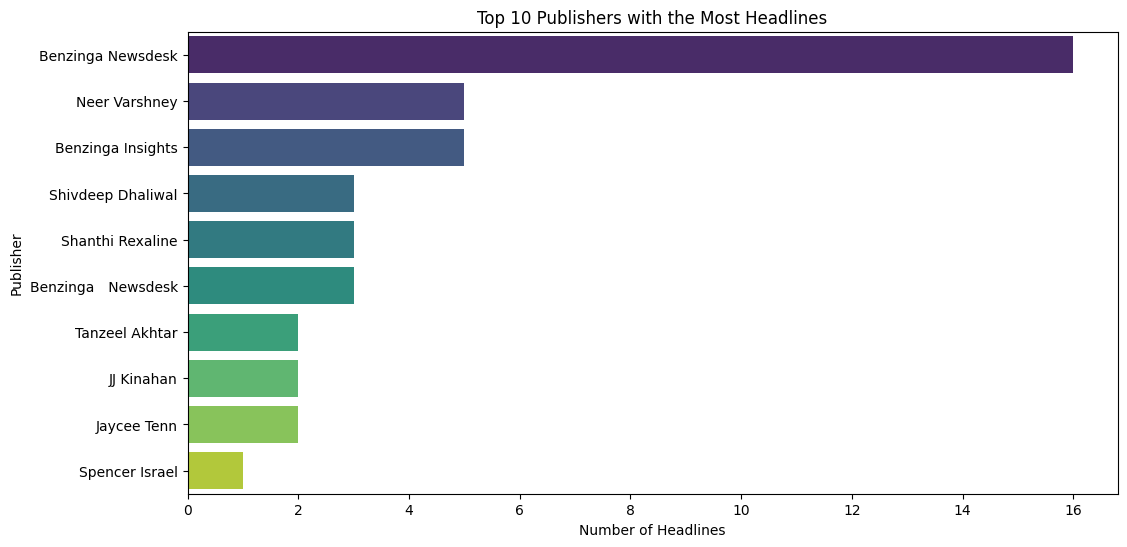

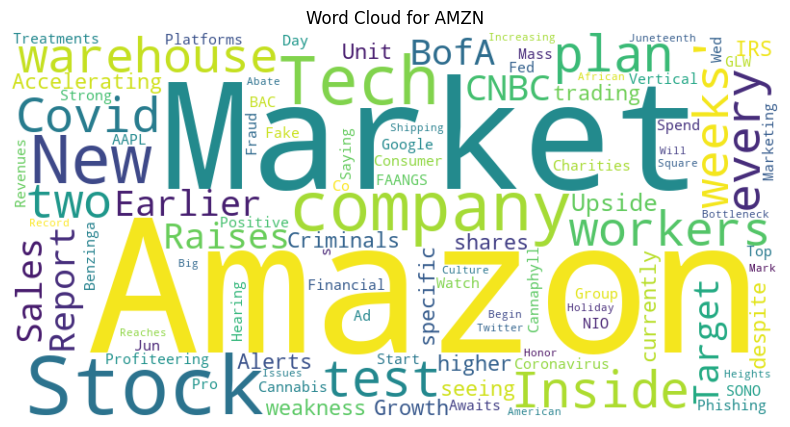

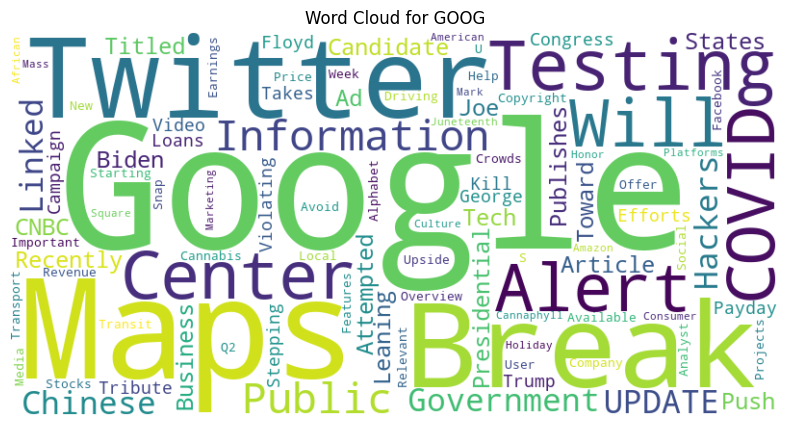

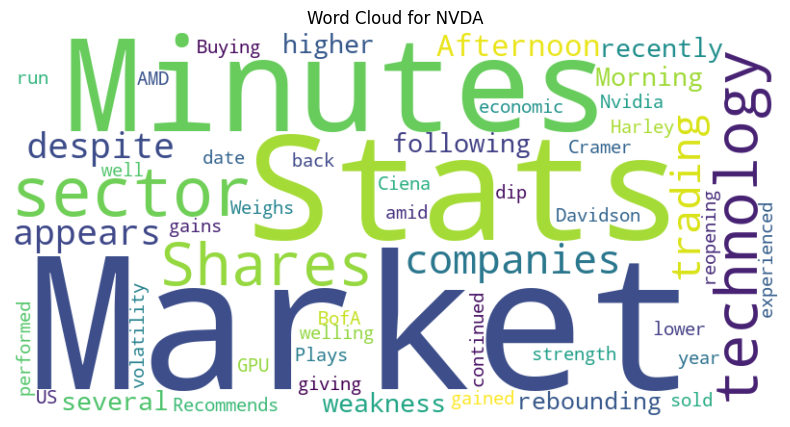

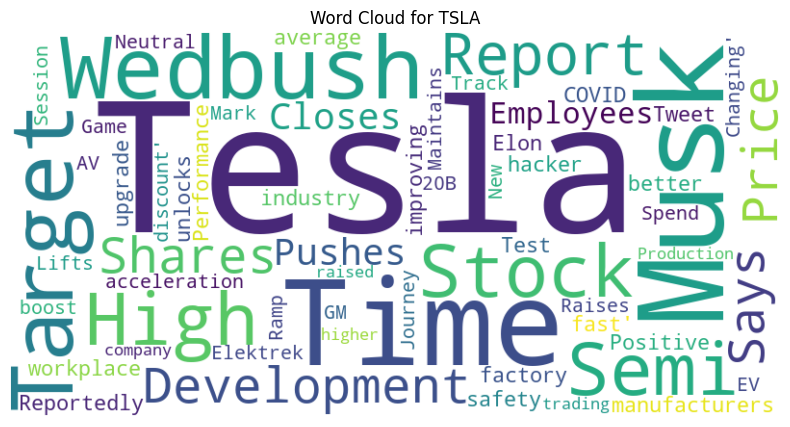

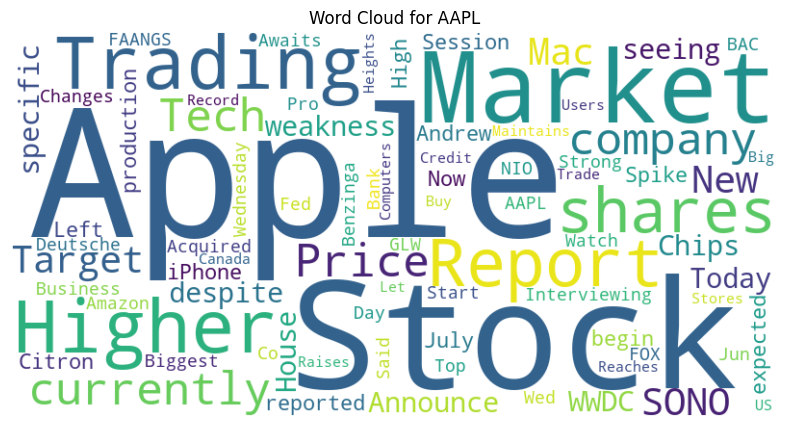

C:\Users\Admin\AppData\Local\Temp\ipykernel_12068\3988238316.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Company')


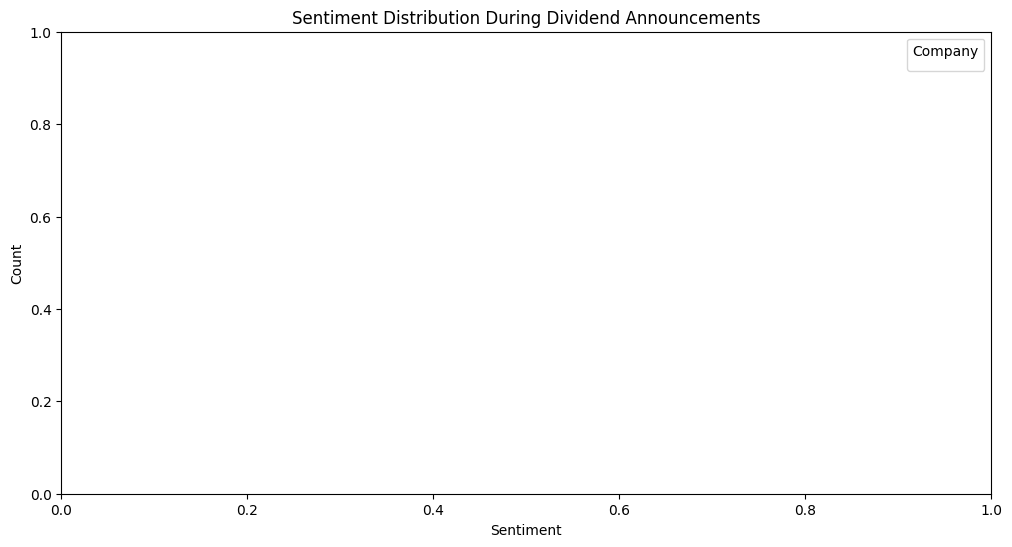

C:\Users\Admin\AppData\Local\Temp\ipykernel_12068\3988238316.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Company')


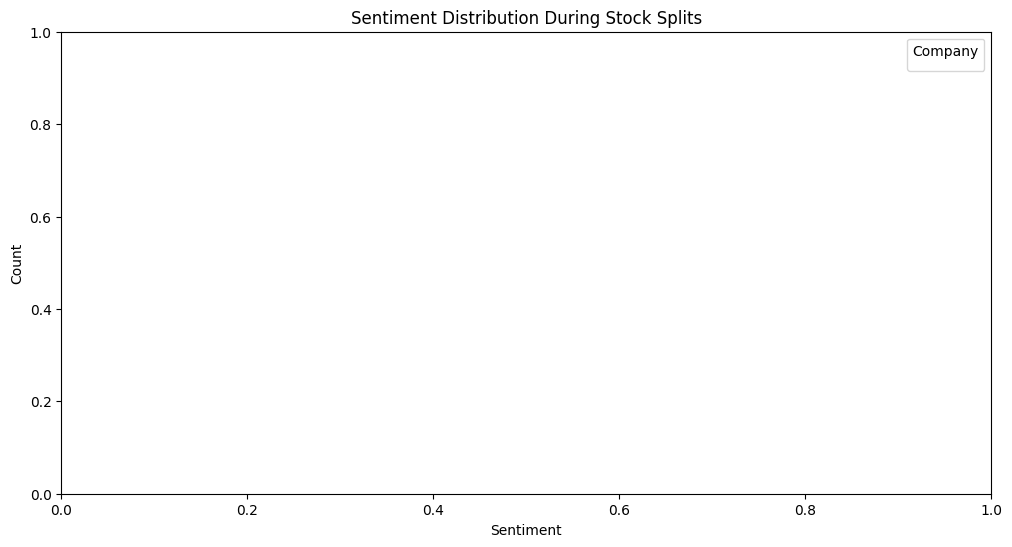

C:\Users\Admin\AppData\Local\Temp\ipykernel_12068\3988238316.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=average_price_changes.index, y=average_price_changes.values, palette='coolwarm')


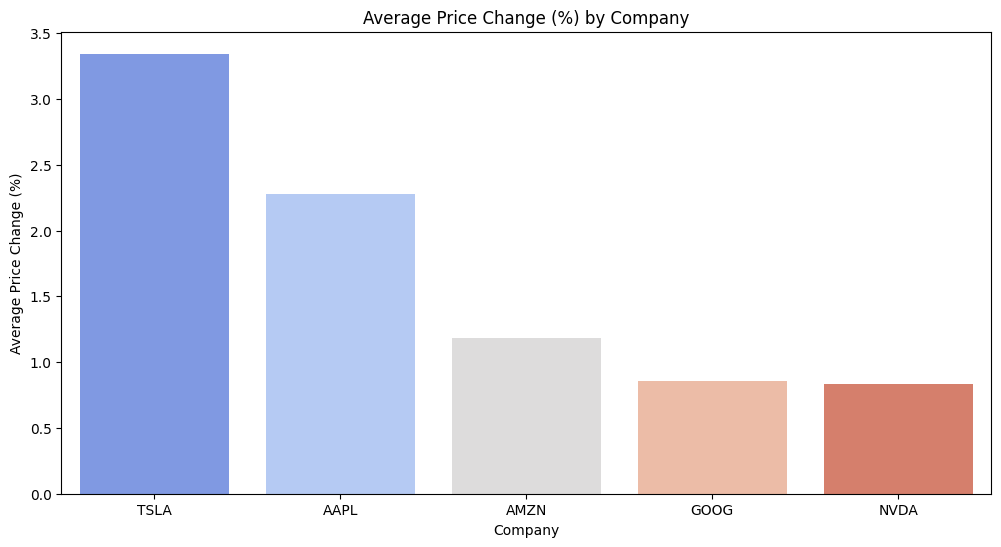

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the engineered dataset
file_path = 'engineered_sentiment_stock_data.csv'  # Replace with actual file path
data = pd.read_csv(file_path)

# Ensure data is properly loaded
if data.empty:
    print("The dataset is empty. Ensure the file path is correct.")
else:
    print(f"Dataset loaded successfully with {len(data)} rows.")

# 1. Sentiment vs. Trading Volume
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='sentiment', y='volume_normalized', hue='company', ci=None)
plt.title('Normalized Trading Volume by Sentiment and Company')
plt.ylabel('Normalized Volume')
plt.xlabel('Sentiment')
plt.legend(title='Company')
plt.show()

# 2. Price Volatility Analysis
data['price_volatility'] = data['high'] - data['low']

plt.figure(figsize=(12, 6))
sns.boxplot(data=data, x='sentiment', y='price_volatility', hue='company')
plt.title('Price Volatility by Sentiment and Company')
plt.ylabel('Price Volatility')
plt.xlabel('Sentiment')
plt.legend(title='Company')
plt.show()

# 3. Temporal Sentiment Trends
plt.figure(figsize=(14, 6))
for company in data['company'].unique():
    company_data = data[data['company'] == company]
    sentiment_counts = company_data.groupby(['date', 'sentiment']).size().unstack(fill_value=0)
    sentiment_counts.plot(kind='line', figsize=(14, 6), title=f"Sentiment Trends Over Time for {company}")
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend(title='Sentiment')
    plt.show()

# 4. Publisher Influence
plt.figure(figsize=(12, 6))
top_publishers = data['publisher'].value_counts().head(10)
sns.barplot(y=top_publishers.index, x=top_publishers.values, palette='viridis')
plt.title('Top 10 Publishers with the Most Headlines')
plt.xlabel('Number of Headlines')
plt.ylabel('Publisher')
plt.show()

# 5. Word Clouds per Company
from wordcloud import WordCloud

companies = data['company'].unique()
for company in companies:
    company_data = data[data['company'] == company]
    text = ' '.join(company_data['headline'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {company}')
    plt.show()

# 6. Sentiments During Dividends and Splits
dividends_data = data[data['dividends'] > 0]
splits_data = data[data['stock splits'] > 0]

plt.figure(figsize=(12, 6))
sns.countplot(data=dividends_data, x='sentiment', hue='company')
plt.title('Sentiment Distribution During Dividend Announcements')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Company')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(data=splits_data, x='sentiment', hue='company')
plt.title('Sentiment Distribution During Stock Splits')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Company')
plt.show()

# 7. Performance Ranking
average_price_changes = data.groupby('company')['price_change_pct'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=average_price_changes.index, y=average_price_changes.values, palette='coolwarm')
plt.title('Average Price Change (%) by Company')
plt.ylabel('Average Price Change (%)')
plt.xlabel('Company')
plt.show()